In [7]:
# %%
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, LayerNormalization, Dense, TimeDistributed, RepeatVector, MultiHeadAttention, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras import mixed_precision
import keras_tuner as kt
import matplotlib.pyplot as plt

# %%
# Ativar Mixed Precision
mixed_precision.set_global_policy('mixed_float16')
print("Política de precisão mista ativada:", mixed_precision.global_policy())

# Verificar disponibilidade da GPU
print("GPUs disponíveis:", tf.config.list_physical_devices('GPU'))

# Definir parâmetros
batch_size = 64  # Ajuste conforme a capacidade da sua GPU
sequence_length = 36  
prediction_length = 1  # Previsão de um passo à frente

# %%
# Carregar o dataset
df = pd.read_csv("dataset.csv")

# Converter 'id' para datetime e definir como índice
df['timestamp'] = pd.to_datetime(df['id'], errors='coerce')
df.set_index('timestamp', inplace=True)

# Selecionar as colunas de interesse
cols = ["humid", "ws100", "wdisp100"]
df_for_training = df[cols].astype(float)

# Escalonar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

print("Dados escalonados com sucesso.")

# %%
# Construção dos conjuntos de dados
X, y = [], []

for i in range(len(df_for_training_scaled) - sequence_length - prediction_length + 1):
    X.append(df_for_training_scaled[i: i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length: i + sequence_length + prediction_length, 1:2])  # 'ws100' está na coluna 1

X = np.array(X)  # Shape: (num_samples, 36, 3)
y = np.array(y)  # Shape: (num_samples, 1, 1)

print(f"Shape de X: {X.shape}")  
print(f"Shape de y: {y.shape}") 

# %%
# Divisão em Conjuntos de Treino e Teste
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Conjunto de Treino - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Conjunto de Teste - X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# %%
# Função de Perda Customizada (opcional)
def custom_loss(y_true, y_pred):
    """
    Função de perda customizada que aplica pesos progressivos aos erros de previsão.
    Adequada para previsão de um único passo à frente.
    """
    # Assegurar que y_true e y_pred tenham três dimensões
    if len(y_true.shape) == 2:
        y_true = tf.expand_dims(y_true, -1)
    if len(y_pred.shape) == 2:
        y_pred = tf.expand_dims(y_pred, -1)

    # Extrair valores de 'ws100'
    y_true_ws100 = y_true[:, :, 0]
    y_pred_ws100 = y_pred[:, :, 0]
    
    # Calcular MSE
    mse_ws100 = tf.square(y_true_ws100 - y_pred_ws100)
    
    # Definir pesos (aqui fixo 1.0, pois é um único passo)
    weight = 1.0
    
    # Aplicar peso
    weighted_mse = mse_ws100 * weight
    
    # Calcular perda média
    loss = tf.reduce_mean(weighted_mse)
    
    return loss

# %%
# Função para Construção do Modelo CNN-LSTM Recursivo
def build_model_cnn(hp):
    # Hiperparâmetros com espaços de busca reduzidos
    filters = hp.Int('filters', min_value=16, max_value=256, step=16)
    kernel_size = hp.Choice('kernel_size', values=[3, 5, 7])
    pool_size = hp.Choice('pool_size', values=[2, 3])
    units = hp.Int('units', min_value=16, max_value=256, step=16)
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    
    # Seleção do Otimizador
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    # Encoder Input
    encoder_inputs = tf.keras.Input(shape=(sequence_length, X_train.shape[2]), name='encoder_input')  # 36 passos de entrada
    x = encoder_inputs
    
    # Camada CNN
    x = Conv1D(
        filters=filters,
        kernel_size=kernel_size,
        activation='relu',
        padding='same',
        kernel_regularizer=l2(1e-4),
        name='conv1d_layer'
    )(x)
    
    # Camada de Pooling
    x = MaxPooling1D(pool_size=pool_size, padding='same', name='maxpool_layer')(x)
    
    # Camadas LSTM
    x = LSTM(
        units=units,
        return_sequences=True,
        activation='tanh',
        dropout=dropout_rate,
        kernel_regularizer=l2(1e-3),
        name=f'lstm_layer_{i}'
    )(x)
    x = LayerNormalization(name=f'lstm_norm_{i}')(x)
    
    # Encoder State (última saída de LSTM)
    encoder_state = x[:, -1, :]
    
    # Decoder Input
    decoder_inputs = RepeatVector(prediction_length, name='repeat_vector')(encoder_state)  # 6 passos de saída
    decoder_outputs = decoder_inputs
    
    # Camadas LSTM no Decoder
    decoder_outputs = LSTM(
        units=units,
        return_sequences=True,
        activation='tanh',
        dropout=dropout_rate,
        kernel_regularizer=l2(1e-3),
        name=f'decoder_lstm_layer_{i}'
    )(decoder_outputs)
    decoder_outputs = LayerNormalization(name=f'decoder_lstm_norm_{i}')(decoder_outputs)
    
    # Atenção Multi-Cabeça (opcional)
    attention = MultiHeadAttention(
        num_heads=hp.Int('num_heads', min_value=2, max_value=6, step=2),
        key_dim=units,
        name='multi_head_attention'
    )(decoder_outputs, x)
    
    attention = Dropout(dropout_rate, name='attention_dropout')(attention)
    decoder_concat_input = Concatenate(axis=-1, name='concat_attention')([decoder_outputs, attention])
    
    # Camada de Saída
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_concat_input)
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Wind_Speed_Predictor_CNN_LSTM')
    
    # Compilação do Modelo
    model.compile(
        optimizer=optimizer,
        loss=custom_loss,
        metrics=[
            tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsoluteError(name='mae')        
        ]
    )
    
    return model

# %%
# Inicialização do Keras Tuner com Hyperband Otimizado
tuner = kt.Hyperband(
    build_model_cnn,  # Função de construção do modelo
    objective='val_loss',            # Métrica a ser minimizada
    max_epochs=20,                   # Número máximo de épocas
    factor=3,                        # Fator de redução no número de épocas
    directory='tuner_dir_recursive', # Diretório para salvar os resultados do tuner
    project_name='wind_speed_prediction_recursive',  # Nome do projeto
    overwrite=True                   # Sobrescrever os resultados anteriores
)

# %%
# Definição dos Callbacks

# EarlyStopping para interromper o treinamento quando a validação não melhora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Número de épocas sem melhora antes de interromper
    restore_best_weights=True
)

# ReduceLROnPlateau para reduzir a taxa de aprendizado quando a validação não melhora
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,     # Fator pelo qual a taxa de aprendizado será reduzida
    patience=3,     # Número de épocas sem melhora antes de reduzir
    min_lr=1e-5     # Taxa de aprendizado mínima
)

# TensorBoard para monitoramento visual do treinamento
tensorboard_callback = TensorBoard(log_dir='./logs_recursive', histogram_freq=1)

# ModelCheckpoint para salvar o melhor modelo baseado na validação
checkpoint = ModelCheckpoint(
    'best_model_recursive2.h5.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# %%
# Converter dados para Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle, batch e prefetch para otimização
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Pipeline de dados configurado.")


Política de precisão mista ativada: <DTypePolicy "mixed_float16">
GPUs disponíveis: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dados escalonados com sucesso.
Shape de X: (7525, 36, 3)
Shape de y: (7525, 1, 1)
Conjunto de Treino - X_train shape: (6020, 36, 3), y_train shape: (6020, 1, 1)
Conjunto de Teste - X_test shape: (1505, 36, 3), y_test shape: (1505, 1, 1)
Pipeline de dados configurado.


In [8]:
# %%
# Execução da Busca de Hiperparâmetros
tuner.search(
    train_dataset,
    validation_data=test_dataset,
    epochs=20,  # Número máximo de épocas para cada trial
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint]
)

Trial 30 Complete [00h 01m 12s]
val_loss: 0.23834426701068878

Best val_loss So Far: 0.005658676847815514
Total elapsed time: 00h 13m 48s


In [16]:
# %%
# Obtenção dos Melhores Hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Melhores hiperparâmetros encontrados: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)

# Treinamento Final do Modelo com os Melhores Hiperparâmetros
history = best_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100  # Número de épocas para o treinamento final
)

Melhores hiperparâmetros encontrados: {'filters': 128, 'kernel_size': 3, 'pool_size': 2, 'units': 192, 'learning_rate': 0.001, 'dropout_rate': 0.4, 'optimizer': 'rmsprop', 'num_heads': 2, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.5652 - mae: 1.2231 - rmse: 2.3575 - val_loss: 0.5768 - val_mae: 0.4226 - val_rmse: 0.4630
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4625 - mae: 0.2884 - rmse: 0.3656 - val_loss: 0.2976 - val_mae: 0.2680 - val_rmse: 0.2932
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2235 - mae: 0.1665 - rmse: 0.2066 - val_loss: 0.2619 - val_mae: 0.3801 - val_rmse: 0.4001
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.1089 - mae: 0.1180 - rmse: 0.1515 - val_loss: 0.0621 - val_mae: 0.0909 - val_rmse: 0.1191
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0599 - mae: 0.1100 - rmse: 0.139

In [17]:
# %%
# Salvamento do Melhor Modelo
best_model.save('best_model_recursive_final.h5.keras')
print("Melhor modelo salvo como 'best_model_recursive_final.h5.keras'.")

# Carregamento do Melhor Modelo (se necessário)
best_model = tf.keras.models.load_model(
    'best_model_recursive_final.h5.keras',
    custom_objects={'custom_loss': custom_loss}
)
print("Melhor modelo carregado para inferência.")

Melhor modelo salvo como 'best_model_recursive_final.h5.keras'.
Melhor modelo carregado para inferência.


In [18]:
# %%
def inverse_scale(y_scaled, scaler, prediction_length=1):
    """
    Inverte a escala dos dados preditivos para o espaço original.
    
    Args:
        y_scaled: Array numpy de dados escalados, shape (num_samples, prediction_length, 1)
        scaler: Instância do MinMaxScaler utilizada para escalar os dados
        prediction_length: Número de passos de previsão (default=1)
        
    Returns:
        y_orig: Array numpy de dados no espaço original, shape (num_samples, prediction_length)
    """
    num_samples = y_scaled.shape[0]
    # Supondo que 'ws100' é a segunda feature (index 1)
    feature_index = 1  # Ajuste se 'ws100' estiver em outro índice
    num_features = scaler.scale_.shape[0]
    
    # Reshape para [num_samples * prediction_length, 1]
    y_scaled_reshaped = y_scaled.reshape(-1, 1)
    
    # Criar arrays de zeros para as outras features
    zeros_before = np.zeros((y_scaled_reshaped.shape[0], feature_index))
    zeros_after = np.zeros((y_scaled_reshaped.shape[0], num_features - feature_index - 1))
    
    # Concatenar zeros antes, y_scaled e zeros depois
    y_scaled_full = np.concatenate([zeros_before, y_scaled_reshaped, zeros_after], axis=1)
    
    # Inverter a escala
    y_orig_full = scaler.inverse_transform(y_scaled_full)
    
    # Extrair a feature de interesse
    y_orig = y_orig_full[:, feature_index]
    
    # Reshape para [num_samples, prediction_length]
    y_orig = y_orig.reshape(num_samples, prediction_length)
    
    return y_orig


In [19]:
# %%
def recursive_prediction(model, X_input, scaler, prediction_length=6):
    """
    Realiza previsões recursivas para múltiplos passos à frente.
    
    Args:
        model: Modelo treinado para prever um passo à frente.
        X_input: Dados de entrada escalonados, shape (num_samples, 36, 3)
        scaler: Instância do MinMaxScaler utilizada para escalar os dados
        prediction_length: Número de passos de previsão (default=6)
        
    Returns:
        predictions_orig: Previsões no espaço original, shape (num_samples, prediction_length)
    """
    predictions = []
    X_current = X_input.copy()
    
    for _ in range(prediction_length):
        # Prever o próximo passo
        y_pred_scaled = model.predict(X_current)  # Shape: (num_samples, 1)
        
        # Inverter a escala
        y_pred_orig = inverse_scale(y_pred_scaled, scaler, prediction_length=1)  # Shape: (num_samples, 1)
        
        # Adicionar a previsão à lista
        predictions.append(y_pred_orig)
        
        # Atualizar X_current para incluir a previsão e remover o primeiro passo
        y_pred_scaled_expanded = y_pred_scaled.reshape(y_pred_scaled.shape[0], 1, y_pred_scaled.shape[-1])  # Shape: (num_samples, 1, 1)
        
        # Criar array de zeros para as outras features
        zeros_features = np.zeros((y_pred_scaled_expanded.shape[0], 1, X_input.shape[-1] - 1))  # Shape: (num_samples, 1, 2)
        
        # Concatenar a previsão de 'ws100' com zeros para as outras features
        y_pred_full = np.concatenate([zeros_features, y_pred_scaled_expanded], axis=-1)  # Shape: (num_samples, 1, 3)
        
        # Atualizar X_current: remover o primeiro passo e adicionar o novo passo
        X_current = np.concatenate([X_current[:, 1:, :], y_pred_full], axis=1)  # Shape: (num_samples, 36, 3)
    
    # Concatenar todas as previsões
    predictions = np.concatenate(predictions, axis=1)  # Shape: (num_samples, 6)
    
    return predictions


In [20]:
# %%
# Realização das Previsões Recursivas
y_pred_orig = recursive_prediction(best_model, X_test, scaler, prediction_length=6)

print("Previsões recursivas realizadas e escalas invertidas.")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Previsões recursivas realizadas e escalas invertidas.


In [21]:

# %%
# Inversão da Escala dos Dados Reais
# 'y_test' tem shape (num_samples, 1, 1), repetimos para 6 passos
y_test_repeated = np.repeat(y_test, repeats=6, axis=1)  # Shape: (num_samples, 6, 1)
y_test_orig = inverse_scale(y_test_repeated, scaler, prediction_length=6)  # Shape: (num_samples, 6)

print("Inversão da escala dos dados reais concluída.")



Inversão da escala dos dados reais concluída.



Avaliação para o passo de tempo 1
'ws100': RMSE = 0.7273, NRMSE = 0.0747, Erro Relativo = 7.60%


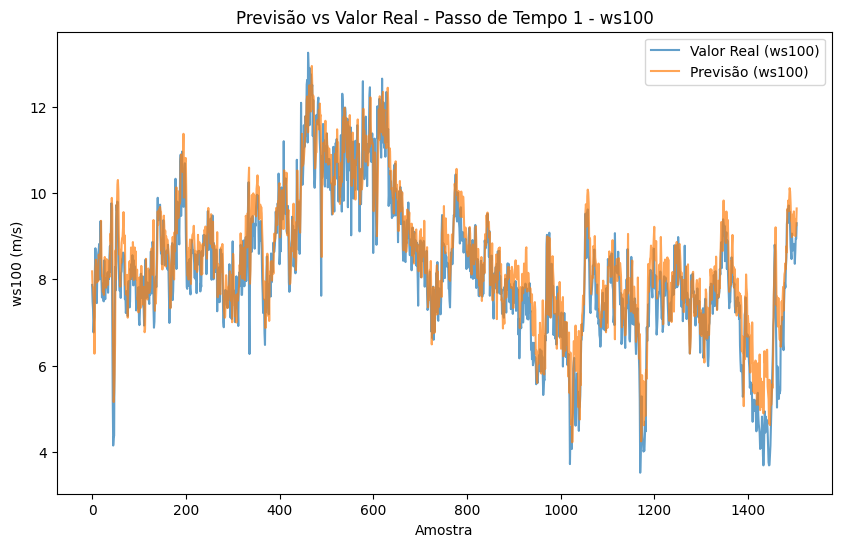


Avaliação para o passo de tempo 2
'ws100': RMSE = 2.7691, NRMSE = 0.2846, Erro Relativo = 29.61%


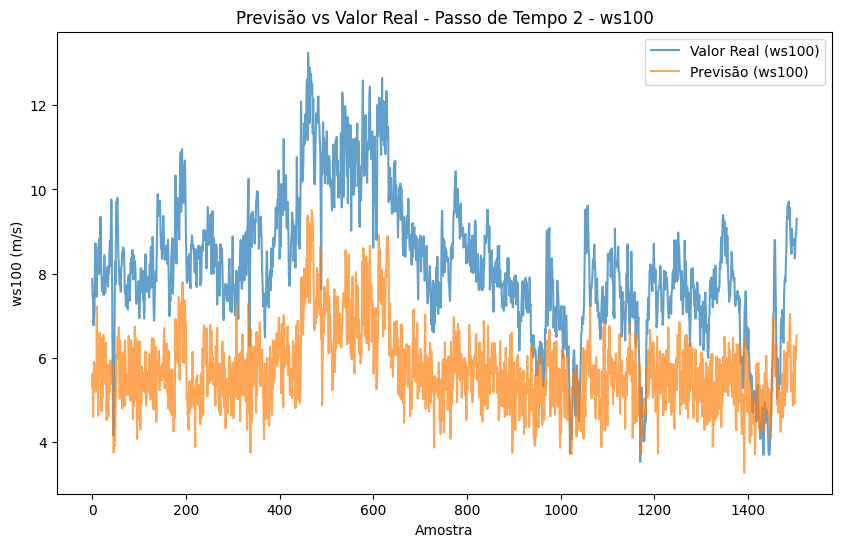


Avaliação para o passo de tempo 3
'ws100': RMSE = 4.1283, NRMSE = 0.4243, Erro Relativo = 44.68%


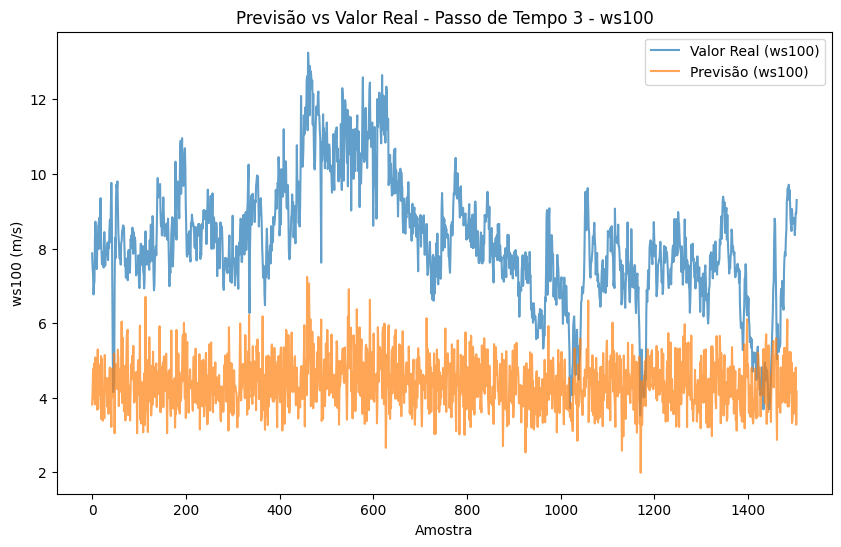


Avaliação para o passo de tempo 4
'ws100': RMSE = 4.6179, NRMSE = 0.4746, Erro Relativo = 50.48%


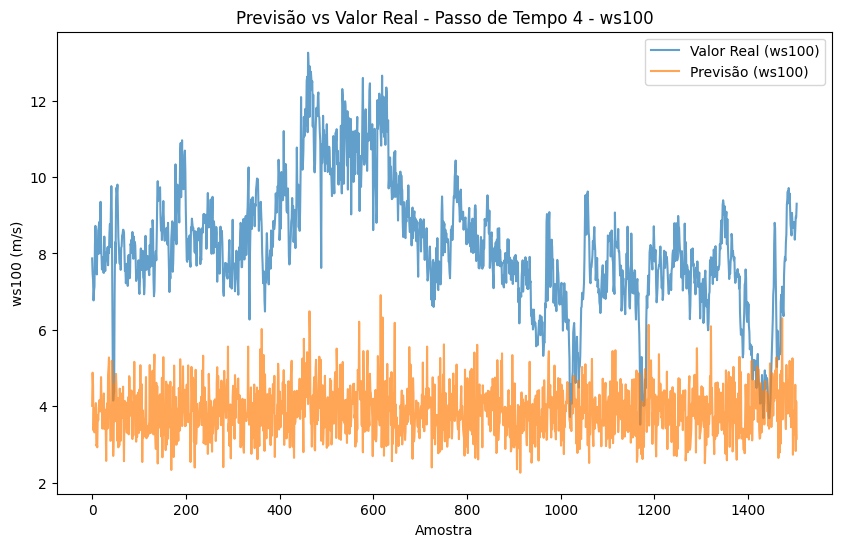


Avaliação para o passo de tempo 5
'ws100': RMSE = 4.9109, NRMSE = 0.5047, Erro Relativo = 53.77%


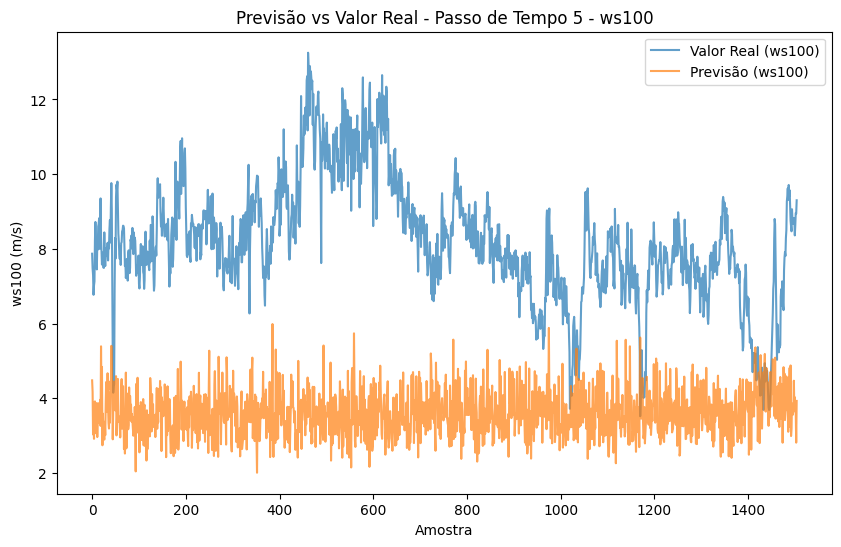


Avaliação para o passo de tempo 6
'ws100': RMSE = 4.8725, NRMSE = 0.5008, Erro Relativo = 52.98%


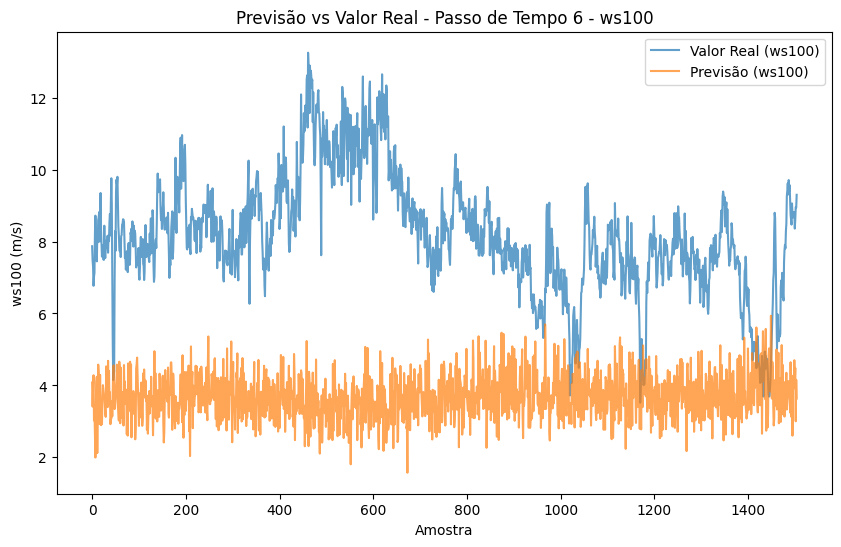

In [22]:
# %%
# Avaliação e Visualização

for t in range(6):
    print(f"\nAvaliação para o passo de tempo {t+1}")
    
    col = 'ws100'
    y_true = y_test_orig[:, t]      # Shape: (num_samples,)
    y_pred_col = y_pred_orig[:, t]  # Shape: (num_samples,)

    # Cálculo das métricas
    rmse = np.sqrt(np.mean((y_true - y_pred_col) ** 2))
    nrmse = rmse / (y_true.max() - y_true.min())
    relative_error = np.mean(np.abs((y_true - y_pred_col) / (y_true + 1e-7))) * 100

    print(f"'{col}': RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}, Erro Relativo = {relative_error:.2f}%")
    
    # Visualização das Previsões
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label=f"Valor Real ({col})", alpha=0.7)
    plt.plot(y_pred_col, label=f"Previsão ({col})", alpha=0.7)
    plt.legend()
    plt.title(f"Previsão vs Valor Real - Passo de Tempo {t+1} - {col}")
    plt.xlabel('Amostra')
    plt.ylabel(f'{col} (m/s)')
    plt.show()
